# Effective Rank and Loss Evolution During Training

Visualization of how the effective rank of the Gram matrix and training loss change during training.

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os

# Path to data directory (relative to notebooks folder)
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), 'data')

# Load results
with open(os.path.join(DATA_DIR, 'DD_R32_D48_results_20251207_183600.json'), 'r') as f:
    results = json.load(f)

print(f"Configuration:")
print(f"  Task rank: {results['rank']}")
print(f"  Network depth: {results['depth']}")
print(f"  Dimension: {results['dim']}")
print(f"  Samples: {results['n_samples']}")
print(f"  Total epochs: {results['epochs']}")

print(f"\nLoss Summary:")
print(f"  Baseline loss: {results['baseline_loss']:.4f}")
print(f"  Final loss: {results['best_final_loss']:.6e}")
print(f"  Improvement: {results['baseline_loss'] / results['best_final_loss']:.1f}x")

# Get loss history
exp = results['experiments'][0]
loss_history = exp['loss_history']
loss_epochs = np.array([h[0] for h in loss_history])
losses = np.array([h[1] for h in loss_history])

# Find min loss
min_loss_idx = np.argmin(losses)
min_loss = losses[min_loss_idx]
min_loss_epoch = loss_epochs[min_loss_idx]
print(f"  Minimum loss: {min_loss:.6e} at epoch {min_loss_epoch}")

if 'erank_history' in results:
    print(f"\nEffective Rank Summary:")
    print(f"  Initial: {results['initial_erank']:.4f}")
    print(f"  Final: {results['final_erank']:.4f}")
    print(f"  Change: {results['final_erank'] - results['initial_erank']:.4f}")
else:
    print("\nNo effective rank history found.")

Configuration:
  Task rank: 32
  Network depth: 48
  Dimension: 64
  Samples: 128
  Total epochs: 200000

Loss Summary:
  Baseline loss: 60.6350
  Final loss: 5.748840e-05
  Improvement: 1054735.4x
  Minimum loss: 5.535101e-05 at epoch 199900

Effective Rank Summary:
  Initial: 2.4144
  Final: 2.4124
  Change: -0.0021


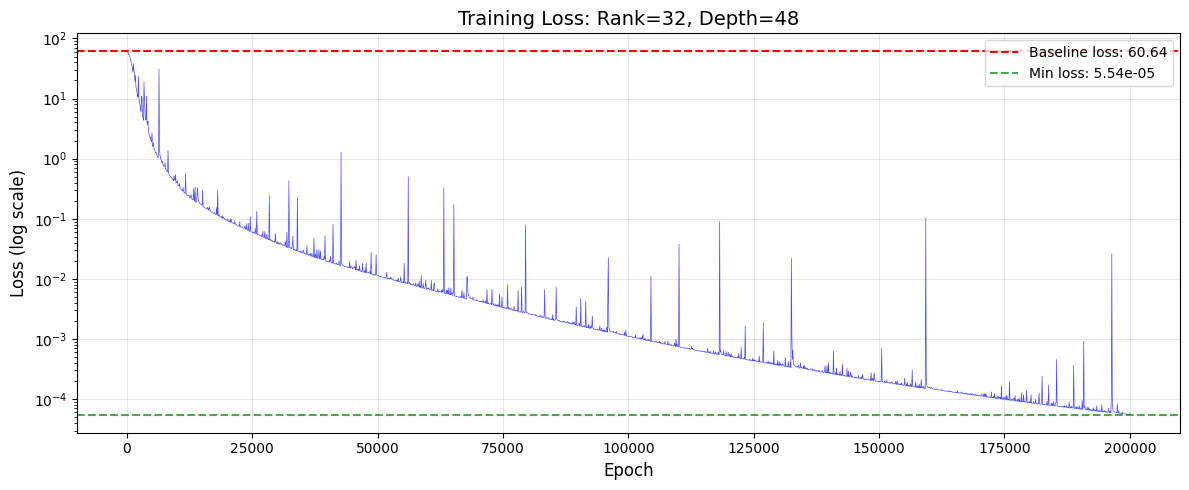

In [2]:
# Plot 1: Training Loss Over Epochs
fig, ax = plt.subplots(figsize=(12, 5))

ax.semilogy(loss_epochs, losses, 'b-', alpha=0.7, linewidth=0.5)
ax.axhline(y=results['baseline_loss'], color='r', linestyle='--', label=f"Baseline loss: {results['baseline_loss']:.2f}")
ax.axhline(y=min_loss, color='g', linestyle='--', alpha=0.7, label=f"Min loss: {min_loss:.2e}")

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss (log scale)', fontsize=12)
ax.set_title(f"Training Loss: Rank={results['rank']}, Depth={results['depth']}", fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('loss_evolution.png', dpi=150)
plt.show()

/tmp/ipykernel_39809/296780408.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


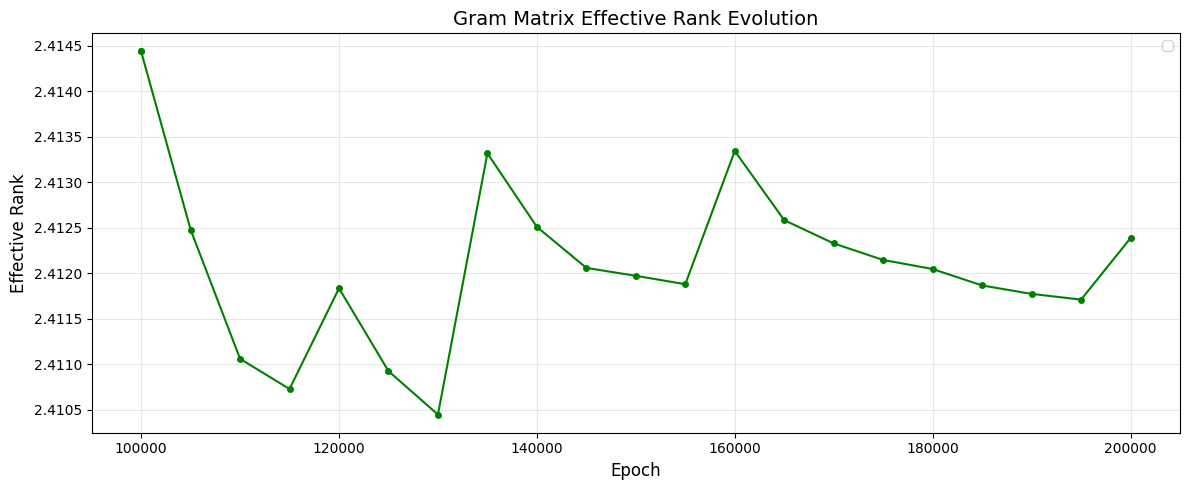


Effective rank range: 2.4104 - 2.4144
Standard deviation: 0.0010


In [3]:
# Plot 2: Effective Rank Over Epochs
if 'erank_history' in results:
    erank_history = results['erank_history']
    erank_epochs = np.array([h[0] for h in erank_history])
    eranks = np.array([h[1] for h in erank_history])
    
    fig, ax = plt.subplots(figsize=(12, 5))
    
    ax.plot(erank_epochs, eranks, 'go-', markersize=4, linewidth=1.5)
    # ax.axhline(y=results['rank'], color='r', linestyle='--', 
    #            label=f"Task rank: {results['rank']}")
    # ax.axhline(y=results['dim'], color='gray', linestyle=':', alpha=0.5,
    #            label=f"Max possible: {results['dim']}")
    
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Effective Rank', fontsize=12)
    ax.set_title(f"Gram Matrix Effective Rank Evolution", fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Set y-axis to show full range for context
    # ax.set_ylim(0, max(results['rank'] + 5, max(eranks) + 2))
    
    plt.tight_layout()
    plt.savefig('erank_evolution.png', dpi=150)
    plt.show()
    
    print(f"\nEffective rank range: {min(eranks):.4f} - {max(eranks):.4f}")
    print(f"Standard deviation: {np.std(eranks):.4f}")
else:
    print("No effective rank history available.")

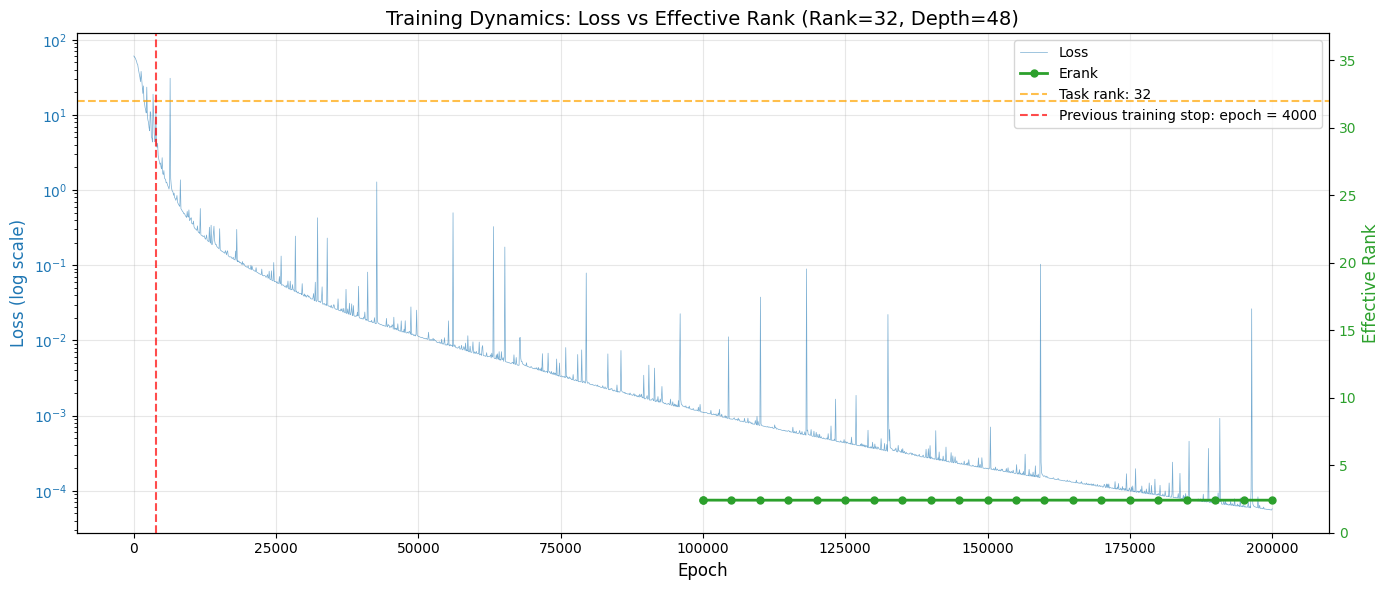

In [4]:
# Plot 3: Combined - Loss and Effective Rank (dual y-axis)
if 'erank_history' in results:
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    # Loss on left y-axis (log scale)
    color1 = 'tab:blue'
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss (log scale)', color=color1, fontsize=12)
    ax1.semilogy(loss_epochs, losses, color=color1, alpha=0.6, linewidth=0.5, label='Loss')
    ax1.tick_params(axis='y', labelcolor=color1)
    # ax1.axhline(y=results['baseline_loss'], color='red', linestyle='--', alpha=0.5, label=f"Baseline: {results['baseline_loss']:.2f}")
    
    # Effective rank on right y-axis
    ax2 = ax1.twinx()
    color2 = 'tab:green'
    ax2.set_ylabel('Effective Rank', color=color2, fontsize=12)
    ax2.plot(erank_epochs, eranks, color=color2, marker='o', markersize=5, linewidth=2, label='Erank')
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.axhline(y=results['rank'], color='orange', linestyle='--', alpha=0.7, label=f"Task rank: {results['rank']}")
    ax2.axvline(x= 4000, color='red', linestyle='--', alpha=0.7, label="Previous training stop: epoch = 4000")
    ax2.set_ylim(0, results['rank'] + 5)
    
    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.title(f"Training Dynamics: Loss vs Effective Rank (Rank={results['rank']}, Depth={results['depth']})", fontsize=14)
    ax1.grid(True, alpha=0.3)

    
    
    plt.tight_layout()
    plt.savefig('loss_vs_erank.png', dpi=150)
    plt.show()

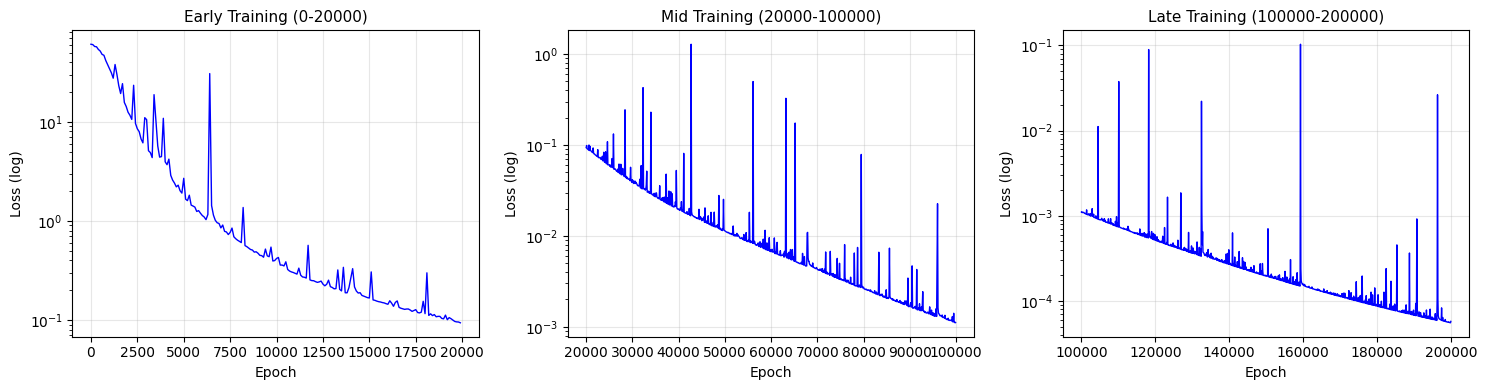


Loss at key epochs:
  Epoch      0 (  0.0%): loss = 6.063921e+01
  Epoch  20000 ( 10.0%): loss = 9.369024e-02
  Epoch  50000 ( 25.0%): loss = 1.135726e-02
  Epoch 100000 ( 50.0%): loss = 1.104971e-03
  Epoch 150000 ( 75.0%): loss = 1.967331e-04
  Epoch 200000 (100.0%): loss = 5.748840e-05


In [5]:
# Plot 4: Loss trajectory in different phases
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Early training (first 10%)
early_cutoff = int(len(loss_epochs) * 0.1)
axes[0].semilogy(loss_epochs[:early_cutoff], losses[:early_cutoff], 'b-', linewidth=1)
axes[0].set_title(f'Early Training (0-{loss_epochs[early_cutoff]:.0f})', fontsize=11)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (log)')
axes[0].grid(True, alpha=0.3)

# Middle training (10-50%)
mid_start = int(len(loss_epochs) * 0.1)
mid_end = int(len(loss_epochs) * 0.5)
axes[1].semilogy(loss_epochs[mid_start:mid_end], losses[mid_start:mid_end], 'b-', linewidth=1)
axes[1].set_title(f'Mid Training ({loss_epochs[mid_start]:.0f}-{loss_epochs[mid_end]:.0f})', fontsize=11)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss (log)')
axes[1].grid(True, alpha=0.3)

# Late training (last 50%)
late_start = int(len(loss_epochs) * 0.5)
axes[2].semilogy(loss_epochs[late_start:], losses[late_start:], 'b-', linewidth=1)
axes[2].set_title(f'Late Training ({loss_epochs[late_start]:.0f}-{loss_epochs[-1]:.0f})', fontsize=11)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss (log)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('loss_phases.png', dpi=150)
plt.show()

# Print loss at key epochs
print("\nLoss at key epochs:")
for frac in [0.0, 0.1, 0.25, 0.5, 0.75, 1.0]:
    idx = min(int(frac * (len(losses) - 1)), len(losses) - 1)
    print(f"  Epoch {loss_epochs[idx]:6.0f} ({frac*100:5.1f}%): loss = {losses[idx]:.6e}")

In [6]:
# Summary statistics and analysis
print("="*70)
print("TRAINING SUMMARY")
print("="*70)

print(f"\nConfiguration:")
print(f"  Task: Y = X @ W where W has rank {results['rank']}")
print(f"  Network: {results['depth']}-layer ReLU MLP, dim={results['dim']}")
print(f"  Data: {results['n_samples']} samples")

print(f"\nTraining:")
print(f"  Total epochs: {results['epochs']:,}")
print(f"  Learning rate: {results['lr']}")

print(f"\nLoss:")
print(f"  Initial (baseline): {results['baseline_loss']:.4f}")
print(f"  Final: {results['best_final_loss']:.6e}")
print(f"  Minimum achieved: {min_loss:.6e} at epoch {min_loss_epoch}")
print(f"  Total reduction: {results['baseline_loss'] / results['best_final_loss']:.1e}x")

if 'erank_history' in results:
    print(f"\nEffective Rank of Gram Matrix K=Phi(X)@Phi(X).T:")
    print(f"  Initial: {results['initial_erank']:.4f}")
    print(f"  Final: {results['final_erank']:.4f}")
    print(f"  Change: {results['final_erank'] - results['initial_erank']:+.4f}")
    print(f"  Range during training: [{min(eranks):.4f}, {max(eranks):.4f}]")
    print(f"  Std dev: {np.std(eranks):.4f}")
    
    print(f"\nAnalysis:")
    if np.std(eranks) < 0.1:
        print(f"  WARNING: Effective rank is nearly constant (~{np.mean(eranks):.2f})")
        print(f"  This suggests the network may be in a 'lazy training' regime")
        print(f"  where mostly the last layer is being updated.")
    
    if results['final_erank'] < results['rank'] / 2:
        print(f"  NOTE: Erank ({results['final_erank']:.2f}) << Task rank ({results['rank']})")
        print(f"  The learned representation has much lower dimensionality than the task.")

print("\n" + "="*70)

TRAINING SUMMARY

Configuration:
  Task: Y = X @ W where W has rank 32
  Network: 48-layer ReLU MLP, dim=64
  Data: 128 samples

Training:
  Total epochs: 200,000
  Learning rate: 0.0002

Loss:
  Initial (baseline): 60.6350
  Final: 5.748840e-05
  Minimum achieved: 5.535101e-05 at epoch 199900
  Total reduction: 1.1e+06x

Effective Rank of Gram Matrix K=Phi(X)@Phi(X).T:
  Initial: 2.4144
  Final: 2.4124
  Change: -0.0021
  Range during training: [2.4104, 2.4144]
  Std dev: 0.0010

Analysis:
  This suggests the network may be in a 'lazy training' regime
  where mostly the last layer is being updated.
  NOTE: Erank (2.41) << Task rank (32)
  The learned representation has much lower dimensionality than the task.

